In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [31]:
import pandas as pd
df=pd.read_csv('spam.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [32]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [33]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [34]:
df_spam=df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [35]:
df_ham=df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [36]:
df_ham_sampled=df_ham.sample(df_spam.shape[0])
df_ham_sampled.shape

(747, 2)

In [37]:
df_balanced=pd.concat([df_spam,df_ham_sampled])
df_balanced.shape

(1494, 2)

In [38]:
df_balanced['Category'].value_counts()

spam    747
ham     747
Name: Category, dtype: int64

In [39]:
df_balanced.head()

,Category,Message
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."


In [40]:
df_balanced['Category']=df_balanced['Category'].map({'ham':0,'spam':1})
df_balanced.head()

,Category,Message
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
5,1,FreeMsg Hey there darling it's been 3 week's n...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...
11,1,"SIX chances to win CASH! From 100 to 20,000 po..."


In [42]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(df_balanced['Message'],df_balanced['Category'], stratify=df_balanced['Category'])

In [43]:
x_train.head()

2611       As usual..iam fine, happy &amp; doing well..:)
3998    Bored housewives! Chat n date now! 0871750.77....
3583    You are right. Meanwhile how's project twins c...
2616           2marrow only. Wed at  &lt;#&gt;  to 2 aha.
3674    Moji just informed me that you saved our lives...
Name: Message, dtype: object

## Importing BERT

In [47]:
preprocess='https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
encoder='https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_preprocess=hub.KerasLayer(preprocess)
bert_encoder=hub.KerasLayer(encoder)

In [48]:
def sentence_embedding(sentences):
    preprocessed_text=bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

sentence_embedding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.843517  , -0.51327264, -0.8884572 , ..., -0.74748856,
        -0.75314724,  0.91964495],
       [-0.8720835 , -0.50543964, -0.94446677, ..., -0.85847515,
        -0.71745354,  0.8808298 ]], dtype=float32)>

In [50]:
e=sentence_embedding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
])

In [51]:
e

<tf.Tensor: shape=(6, 768), dtype=float32, numpy=
array([[-0.76069176, -0.14219394,  0.4960459 , ...,  0.42165306,
        -0.5322142 ,  0.8031218 ],
       [-0.86023223, -0.21242936,  0.4915693 , ...,  0.3979806 ,
        -0.6050628 ,  0.84471637],
       [-0.712886  , -0.15463904,  0.3840168 , ...,  0.3527874 ,
        -0.5099133 ,  0.73474073],
       [-0.82533467, -0.35550585, -0.590697  , ..., -0.01613702,
        -0.6141757 ,  0.87230295],
       [-0.75041336, -0.26812622, -0.26689756, ...,  0.02839338,
        -0.5938099 ,  0.7974989 ],
       [-0.7854437 , -0.2994969 ,  0.41027388, ...,  0.5222541 ,
        -0.4957355 ,  0.815075  ]], dtype=float32)>

In [55]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]],[e[2]]) #values 1,2,3 are similar

array([[0.99110883]], dtype=float32)

In [56]:
cosine_similarity([e[0]],[e[3]])

array([[0.84703845]], dtype=float32)

In [57]:
cosine_similarity([e[4]],[e[3]])

array([[0.98720354]], dtype=float32)

In [58]:
#Bert layers
text_input=tf.keras.layers.Input(shape=(), dtype=tf.string, name='text') #input layer
preprocessed_text=bert_preprocess(text_input)
outputs=bert_encoder(preprocessed_text)

#Neural network layers
l=tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l=tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

#Use inputs and outputs to construct a final model
model=tf.keras.Model(inputs=[text_input],outputs=[l])

In [59]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_4 (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [60]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [62]:
model.fit(x_train,y_train,epochs=10)

Epoch 1/10
35/35 [==============================] - 215s 6s/step - loss: 0.6438 - accuracy: 0.6545 - precision: 0.6576 - recall: 0.6446
Epoch 2/10
35/35 [==============================] - 220s 6s/step - loss: 0.5275 - accuracy: 0.7911 - precision: 0.7850 - recall: 0.8018
Epoch 3/10
35/35 [==============================] - 207s 6s/step - loss: 0.4440 - accuracy: 0.8509 - precision: 0.8370 - recall: 0.8714
Epoch 4/10
35/35 [==============================] - 258s 7s/step - loss: 0.4075 - accuracy: 0.8545 - precision: 0.8336 - recall: 0.8857
Epoch 5/10
35/35 [==============================] - 324s 9s/step - loss: 0.3687 - accuracy: 0.8795 - precision: 0.8670 - recall: 0.8964
Epoch 6/10
35/35 [==============================] - 320s 9s/step - loss: 0.3507 - accuracy: 0.8795 - precision: 0.8596 - recall: 0.9071
Epoch 7/10
35/35 [==============================] - 319s 9s/step - loss: 0.3291 - accuracy: 0.8839 - precision: 0.8644 - recall: 0.9107
Epoch 8/10
35/35 [==============================

In [63]:
model.evaluate(x_test,y_test)

12/12 [==============================] - 112s 9s/step - loss: 0.2673 - accuracy: 0.9064 - precision: 0.8958 - recall: 0.9198


[0.26732560992240906,
 0.9064171314239502,
 0.8958333134651184,
 0.9197860956192017]

In [73]:
y_predicted=model.predict(x_test)
y_predicted=y_predicted.flatten()

12/12 [==============================] - 106s 9s/step


In [74]:
import numpy as np
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,

In [75]:
from sklearn.metrics import confusion_matrix, classification_report
cm=confusion_matrix(y_test, y_predicted)
cm 

array([[167,  20],
       [ 15, 172]], dtype=int64)

Text(50.722222222222214, 0.5, 'Truth')

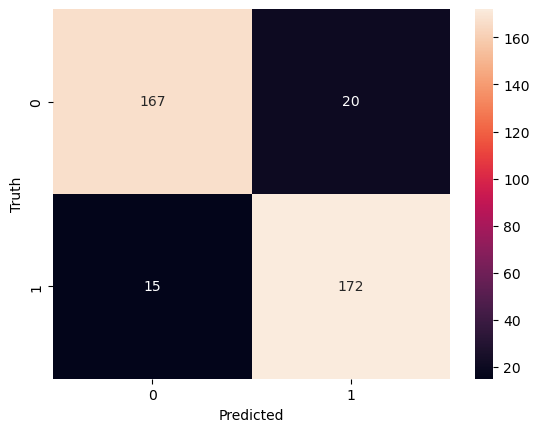

In [76]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [77]:
print(classification_report(y_test,y_predicted))

              precision    recall  f1-score   support

           0       0.92      0.89      0.91       187
           1       0.90      0.92      0.91       187

    accuracy                           0.91       374
   macro avg       0.91      0.91      0.91       374
weighted avg       0.91      0.91      0.91       374



In [78]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 3s 3s/step


array([[0.7084913 ],
       [0.81455404],
       [0.7431124 ],
       [0.18311945],
       [0.10480259]], dtype=float32)